# 03 - E-Commerce Funnel Analysis

**Goal:** Analyze customer behavior through the purchase funnel and identify optimization opportunities


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

print("✅ Libraries imported")


✅ Libraries imported


In [2]:
df = pd.read_csv("../data/processed/cleaned_purchases.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

print(f"Rows: {len(df):,}")
print(f"Customers: {df['CustomerID'].nunique():,}")
print(f"Revenue: £{df['TotalPrice'].sum():,.2f}")


Rows: 392,119
Customers: 4,277
Revenue: £6,545,566.90


In [3]:
# Ensure YearMonth exists
if "YearMonth" not in df.columns:
    df["YearMonth"] = df["InvoiceDate"].dt.to_period("M").astype(str)

# Clean CustomerSegment
if "CustomerSegment" in df.columns:
    df["CustomerSegment"] = (
        df["CustomerSegment"]
        .astype(str)
        .str.strip()
        .str.title()
        .replace({"Uk": "UK"})
    )

print("✅ Safety checks complete")

✅ Safety checks complete


In [4]:
customer_metrics = df.groupby("CustomerID").agg({
    "InvoiceNo": "nunique",
    "TotalPrice": "sum",
    "InvoiceDate": ["min", "max"],
    "YearMonth": "nunique"
}).reset_index()

customer_metrics.columns = [
    "CustomerID",
    "NumOrders",
    "TotalSpent",
    "FirstPurchase",
    "LastPurchase",
    "MonthsActive"
]

customer_metrics["DaysSinceFirst"] = (
    customer_metrics["LastPurchase"] - customer_metrics["FirstPurchase"]
).dt.days

customer_metrics.head()


,CustomerID,NumOrders,TotalSpent,FirstPurchase,LastPurchase,MonthsActive,DaysSinceFirst
0,12347.0,7,4060.40,2010-12-07 14:57:00,2011-12-07 15:52:00,7,365
1,12348.0,4,1306.68,2010-12-16 19:09:00,2011-09-25 13:13:00,4,282
2,12349.0,1,1457.55,2011-11-21 09:51:00,2011-11-21 09:51:00,1,0
3,12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,1,0
4,12352.0,8,1849.49,2011-02-16 12:33:00,2011-11-03 14:37:00,4,260


In [5]:
total_customers = len(customer_metrics)
engaged = customer_metrics[customer_metrics["NumOrders"] >= 2]
repeat = customer_metrics[customer_metrics["MonthsActive"] >= 2]

high_value_threshold = customer_metrics["TotalSpent"].quantile(0.80)
high_value = customer_metrics[customer_metrics["TotalSpent"] >= high_value_threshold]

funnel_df = pd.DataFrame({
    "Stage": [
        "Active Customers",
        "Engaged (2+ Orders)",
        "Repeat (2+ Months)",
        "High-Value (Top 20%)"
    ],
    "Count": [
        total_customers,
        len(engaged),
        len(repeat),
        len(high_value)
    ]
})

funnel_df["Conversion_Rate"] = (funnel_df["Count"] / total_customers * 100).round(2)

funnel_df["Prev_Count"] = funnel_df["Count"].shift(1)
funnel_df["Drop_Off"] = (funnel_df["Prev_Count"] - funnel_df["Count"]).fillna(0)
funnel_df["Drop_Off_Rate"] = (
    funnel_df["Drop_Off"] / funnel_df["Prev_Count"] * 100
).round(2)

funnel_df.drop(columns="Prev_Count", inplace=True)
funnel_df


,Stage,Count,Conversion_Rate,Drop_Off,Drop_Off_Rate
0,Active Customers,4277,100.00,0.0,NaN
1,Engaged (2+ Orders),2796,65.37,1481.0,34.63
2,Repeat (2+ Months),2664,62.29,132.0,4.72
3,High-Value (Top 20%),856,20.01,1808.0,67.87


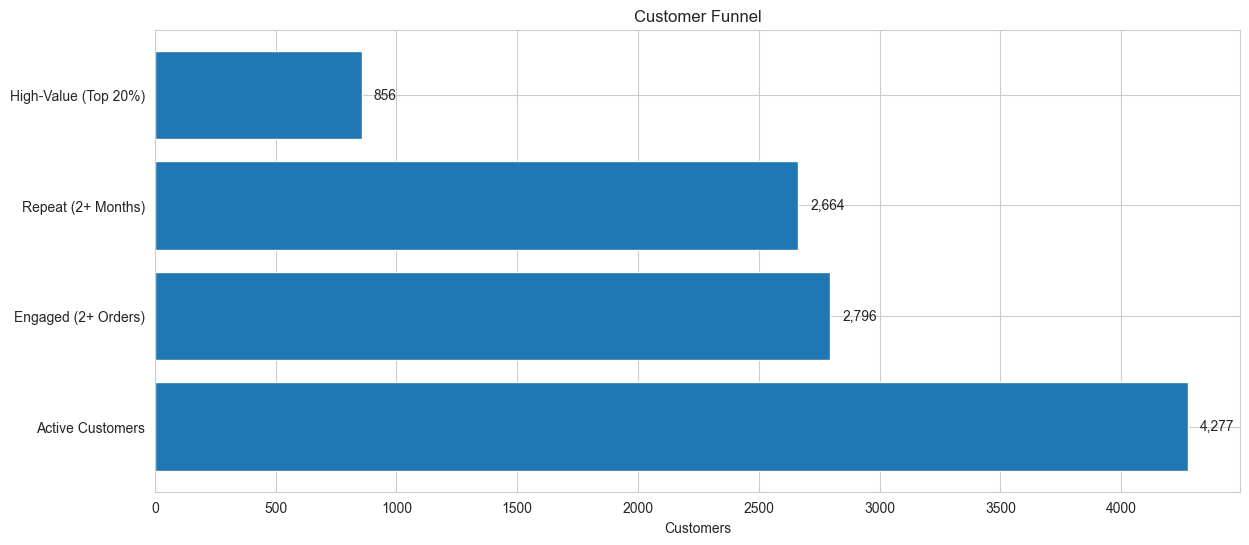

In [6]:
fig, ax = plt.subplots()

ax.barh(funnel_df["Stage"], funnel_df["Count"])
ax.set_title("Customer Funnel")
ax.set_xlabel("Customers")

for i, v in enumerate(funnel_df["Count"]):
    ax.text(v + 50, i, f"{v:,}", va="center")

plt.show()


In [7]:
segment_map = df.groupby("CustomerID")["CustomerSegment"].first()
customer_metrics = customer_metrics.merge(segment_map, on="CustomerID", how="left")

segment_summary = customer_metrics.groupby("CustomerSegment").agg({
    "CustomerID": "count",
    "NumOrders": "mean",
    "TotalSpent": ["mean", "sum"],
    "MonthsActive": "mean"
}).round(2)

segment_summary.columns = [
    "Customers",
    "Avg Orders",
    "Avg Spend",
    "Total Revenue",
    "Avg Months Active"
]

segment_summary


,Customers,Avg Orders,Avg Spend,Total Revenue,Avg Months Active
CustomerSegment,,,,,
International,416,4.39,2670.56,1110951.85,3.01
UK,3861,4.16,1407.57,5434615.05,2.99


In [8]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,7,4060.40
1,12348.0,75,4,1306.68
2,12349.0,19,1,1457.55
3,12350.0,310,1,334.40
4,12352.0,36,8,1849.49


In [9]:
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1], duplicates="drop")
rfm["F_Score"] = pd.qcut(
    rfm["Frequency"].rank(method="first"),
    5,
    labels=[1,2,3,4,5],
    duplicates="drop"
)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5], duplicates="drop")

rfm["RFM_Total"] = rfm[["R_Score", "F_Score", "M_Score"]].astype(int).sum(axis=1)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Total
0,12347.0,2,7,4060.40,5,5,5,15
1,12348.0,75,4,1306.68,2,4,4,10
2,12349.0,19,1,1457.55,4,1,4,9
3,12350.0,310,1,334.40,1,1,2,4
4,12352.0,36,8,1849.49,3,5,4,12


In [10]:
def segment_customer(row):
    r, f, m = int(row.R_Score), int(row.F_Score), int(row.M_Score)
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    elif f >= 4 and m >= 4:
        return "Big Spenders"
    elif r >= 4 and f >= 3:
        return "Loyal"
    elif r >= 4:
        return "Promising"
    elif r <= 2:
        return "At Risk"
    else:
        return "Need Attention"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)
rfm["Segment"].value_counts()


Segment
At Risk           1541
Champions          959
Need Attention     598
Loyal              475
Big Spenders       391
Promising          313
Name: count, dtype: int64

In [11]:
product_performance = df.groupby(["StockCode", "Description"]).agg({
    "Quantity": "sum",
    "TotalPrice": "sum",
    "InvoiceNo": "nunique"
}).reset_index()

product_performance.columns = [
    "StockCode",
    "Description",
    "TotalQuantity",
    "Revenue",
    "Orders"
]

product_performance.sort_values("Revenue", ascending=False).head(10)


,StockCode,Description,TotalQuantity,Revenue,Orders
1315,22423,REGENCY CAKESTAND 3 TIER,7271,86372.50,1606
3451,85123A,WHITE HANGING HEART T-LIGHT HOLDER,22012,60427.56,1919
3888,POST,POSTAGE,2921,60245.27,1070
3436,85099B,JUMBO BAG RED RETROSPOT,29871,56676.88,1541
2791,47566,PARTY BUNTING,7561,36958.83,1270
3270,84879,ASSORTED COLOUR BIRD ORNAMENT,21794,36820.34,1319
999,22086,PAPER CHAIN KIT 50'S CHRISTMAS,9725,27636.23,940
174,20725,LUNCH BAG RED RETROSPOT,16947,26960.95,1284
1282,22386,JUMBO BAG PINK POLKADOT,13765,26129.59,847
1854,22960,JAM MAKING SET WITH JARS,6281,25290.97,857


In [12]:
rfm.to_csv("../data/processed/rfm_analysis.csv", index=False)
customer_metrics.to_csv("../data/processed/customer_metrics.csv", index=False)
product_performance.to_csv("../data/processed/product_performance.csv", index=False)

print("✅ All outputs saved")


✅ All outputs saved
